# Spark Funds Investment case study

### Loading libraries and files

In [1]:
import pandas as pd
import numpy as np
import PyPDF2
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
import pprint

In [2]:
file1 = 'C:/Users/Sheshu/IIITB_/Data files/companies.txt'
file2 = 'C:/Users/Sheshu/IIITB_/Data files/rounds2.csv'
file3 = 'C:/Users/Sheshu/IIITB_/Data files/mapping.csv'
file4 = 'C:/Users/Sheshu/IIITB_/Data files/Countries_where_English_is_an_official_language.pdf'

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
#reading all the files with the same encoding
df_companies = pd.read_csv(file1, sep='\t', encoding='ISO-8859-1')
df_rounds = pd.read_csv(file2, sep=',', encoding='ISO-8859-1')
df_sector_mapping = pd.read_csv(file3, sep=',', encoding='ISO-8859-1')

In [5]:
#function to calculate missing values sum, percentage
def missing_values(x, args='sum'):
    mv = x.isnull().sum()
    if args == 'perc':
        mp = round(100*mv/len(x), 2)
        print('% of Missing values per column\n{}'.format(mp))
    else:
        print('Sum of Missing values per column\n{}'.format(mv))

In [6]:
df3 = pd.read_csv(file3)

### Data Initial analysis

In [7]:
df_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 10 columns):
permalink        66368 non-null object
name             66367 non-null object
homepage_url     61310 non-null object
category_list    63220 non-null object
status           66368 non-null object
country_code     59410 non-null object
state_code       57821 non-null object
region           58338 non-null object
city             58340 non-null object
founded_at       51147 non-null object
dtypes: object(10)
memory usage: 5.1+ MB


In [8]:
df_companies.sample(10)

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
33493,/Organization/Lumicara,Lumicara,http://www.lumicara.com,Consumer Lending|E-Commerce|Emerging Markets|H...,operating,SGP,NaN,NaN,NaN,01-08-2014
66315,/Organization/Zuujit,Zuujit,http://www.zuujit.com,E-Commerce,closed,USA,CA,Santa Barbara,Santa Barbara,01-01-2010
23668,/Organization/Gorkha,Gorkha,http://digitalgorkha.com,Travel & Tourism,operating,IND,16,Mumbai,Mumbai,01-02-2014
63319,/Organization/Webcurfew,WebCurfew,http://www.webcurfew.com,Curated Web|Finance|Home Automation|Internet o...,operating,USA,IL,Chicago,Chicago,01-05-2013
41308,/Organization/Optivia,OptiVia,http://www.optiviamedical.com/,NaN,closed,USA,NC,Winston-Salem,Winston Salem,NaN
10604,/Organization/Challengepost,ChallengePost,http://www.challengepost.com,Curated Web|Developer APIs|Developer Tools|Dev...,operating,USA,NY,New York City,New York,01-01-2009
23928,/Organization/Greekdrop,Greekdrop,http://www.greekdrop.com,E-Commerce,operating,USA,CA,Sacramento,Davis,01-08-2012
45278,/Organization/Procare-Restoration-Services,ProCare Restoration Services,http://www.procareteam.com/,Real Estate,operating,USA,MI,Grand Rapids,Grand Rapids,04-01-2010
47752,/Organization/Remocean,remocean,http://www.remocean.it,Geospatial|Hardware + Software|Predictive Anal...,operating,ITA,4,Napoli,Napoli,01-01-2010
11034,/Organization/Chronicled,Chronicled,http://chronicled.com,E-Commerce|Internet|Technology,operating,USA,CA,SF Bay Area,San Francisco,NaN


In [9]:
df_rounds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114949 entries, 0 to 114948
Data columns (total 6 columns):
company_permalink          114949 non-null object
funding_round_permalink    114949 non-null object
funding_round_type         114949 non-null object
funding_round_code         31140 non-null object
funded_at                  114949 non-null object
raised_amount_usd          94959 non-null float64
dtypes: float64(1), object(5)
memory usage: 5.3+ MB


In [10]:
df_rounds.company_permalink.describe()

count                       114949
unique                       90247
top       /ORGANIZATION/SOLARFLARE
freq                            10
Name: company_permalink, dtype: object

In [11]:
df_rounds.sample(5)

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
114399,/ORGANIZATION/ZIPSCENE,/funding-round/14a5a687f4e39523d5a33a6cc12967fd,seed,NaN,01-01-2011,nan
15337,/ORGANIZATION/BROMIUM,/funding-round/0034c275271eac561977bd9a630f8c68,venture,NaN,01-04-2012,"100,000.00"
22898,/organization/connecttohome,/funding-round/e007a0e31f841dcd3ba7df07373b5f79,grant,NaN,19-09-2013,"20,000.00"
17185,/ORGANIZATION/CARDIOVASCULAR-SIMULATION,/funding-round/fbc6db2f21076faad631e96c12f83d07,venture,NaN,19-04-2010,"1,600,000.00"
99835,/ORGANIZATION/THE-SCHOLARS-CLUB-INC,/funding-round/e955ec41b1c6ab80558d07f0abc1c10d,seed,NaN,01-08-2012,"10,000.00"


#### Data cleaning####

before comparing the list of companies in both the dataframes we need to cleanse the key colummns __'permalink'__ and __'company_permalink'__. By converting them to lower/upper case.

In [12]:
set(df_rounds.company_permalink.str.upper())-set(df_companies.permalink.str.upper())

{'/ORGANIZATION/E-CÃ\x8aBICA',
 '/ORGANIZATION/ENERGYSTONE-GAMES-Ç\x81ΜÇ\x9f³Æ¸¸Æ\x88\x8f',
 '/ORGANIZATION/HUIZUCHE-COM-Æ\x83\xa0Ç§ŸÈ½¦',
 '/ORGANIZATION/MAGNET-TECH-Ç£\x81Ç\x9f³Ç§\x91Æ\x8a\x80',
 '/ORGANIZATION/TIPCAT-INTERACTIVE-Æ²\x99È\x88ŸÄ¿¡Æ\x81¯Ç§\x91Æ\x9a\x80',
 '/ORGANIZATION/WEICHE-TECH-Å\x96\x82È½¦Ç§\x91Æ\x8a\x80',
 '/ORGANIZATION/ZENGAME-Ç¦\x85Æ¸¸Ç§\x91Æ\x8a\x80'}

In [13]:
set(df_companies.permalink.str.upper())-set(df_rounds.company_permalink.str.upper())

{'/ORGANIZATION/E-CÃ\x9aBICA',
 '/ORGANIZATION/ENERGYSTONE-GAMES-Ç\x81ΜÇŸ³Æ¸¸Æ\x88\x8f',
 '/ORGANIZATION/HUIZUCHE-COM-Æ\x83\xa0Ç§\x9fÈ½¦',
 '/ORGANIZATION/TIPCAT-INTERACTIVE-Æ²\x99È\x88\x9fÄ¿¡Æ\x81¯Ç§\x91Æ\x9a\x80',
 '/ORGANIZATION/ZENGAME-Ç¦\x85Æ¸¸Ç§\x91Æ\x9a\x80'}

as we can see from the results there are common values in both the columns but are embedded with different non readable characters. so we need to remove those to get clean values.

In [14]:
df_companies.permalink = df_companies.permalink.apply(lambda x: x.strip().upper().encode('ISO-8859-1', 'ignore').decode('ascii', 'ignore'))

In [15]:
df_rounds.company_permalink = df_rounds.company_permalink.apply(lambda x: x.strip().upper().encode('ISO-8859-1', 'ignore').decode('ascii', 'ignore'))

In [16]:
set(df_rounds.company_permalink.str.upper())-set(df_companies.permalink.str.upper())

set()

Therefore this confirms that there are no companies in rounds2 that aren't there in companies dataset. we can merge the two frames on this common key columns.

###  Funding type Analysis

In [17]:
master_frame = pd.merge(df_rounds, df_companies, left_on='company_permalink', right_on='permalink', how='inner')

In [18]:
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114949 entries, 0 to 114948
Data columns (total 16 columns):
company_permalink          114949 non-null object
funding_round_permalink    114949 non-null object
funding_round_type         114949 non-null object
funding_round_code         31140 non-null object
funded_at                  114949 non-null object
raised_amount_usd          94959 non-null float64
permalink                  114949 non-null object
name                       114948 non-null object
homepage_url               108815 non-null object
category_list              111539 non-null object
status                     114949 non-null object
country_code               106271 non-null object
state_code                 104003 non-null object
region                     104782 non-null object
city                       104785 non-null object
founded_at                 94428 non-null object
dtypes: float64(1), object(15)
memory usage: 14.9+ MB


In [19]:
master_frame.company_permalink.describe()

count                       114949
unique                       66368
top       /ORGANIZATION/SOLARFLARE
freq                            19
Name: company_permalink, dtype: object

In [20]:
missing_values(master_frame)

Sum of Missing values per column
company_permalink              0
funding_round_permalink        0
funding_round_type             0
funding_round_code         83809
funded_at                      0
raised_amount_usd          19990
permalink                      0
name                           1
homepage_url                6134
category_list               3410
status                         0
country_code                8678
state_code                 10946
region                     10167
city                       10164
founded_at                 20521
dtype: int64


In [21]:
missing_values(master_frame, 'perc')

% of Missing values per column
company_permalink          0.00
funding_round_permalink    0.00
funding_round_type         0.00
funding_round_code        72.91
funded_at                  0.00
raised_amount_usd         17.39
permalink                  0.00
name                       0.00
homepage_url               5.34
category_list              2.97
status                     0.00
country_code               7.55
state_code                 9.52
region                     8.84
city                       8.84
founded_at                17.85
dtype: float64


#### Dealing with missing values



firstly we would deal with the column __'raised_amount_usd'__, ideally we could impute them with the most representative value or the lowest value, but to be on the safer side we will drop them as without this info the, row data is almost useless to our analysis.

once we have all the rows where there are no missing values in column __'raised_amount_usd'__, only then we can proceed with dealing of missing row values of other columns. Because if we drop missing row values from other columns first, we might also lose row values in __'raised_amount_usd'__ column which are not null.


In [22]:
master_frame = master_frame[pd.notnull(master_frame['raised_amount_usd'])]

In [23]:
missing_values(master_frame, 'perc')

% of Missing values per column
company_permalink          0.00
funding_round_permalink    0.00
funding_round_type         0.00
funding_round_code        70.34
funded_at                  0.00
raised_amount_usd          0.00
permalink                  0.00
name                       0.00
homepage_url               4.56
category_list              1.10
status                     0.00
country_code               6.16
state_code                 8.01
region                     7.42
city                       7.42
founded_at                16.81
dtype: float64


the column __'funding_round_code'__ can be dropped as it has very high percentage of missing values.

Also except __'funding_round_type', 'country_code', 'category_list'__  and  __'raised_amount_usd', 'company_permalink', 'name'__ , the other columns are not of much value for our current analysis.

so we can drop those.

In [24]:
dropcols = ['status','state_code','region','city','funded_at', 'founded_at', 'permalink', 'funding_round_code', 'homepage_url']

In [25]:
master_frame = master_frame.drop(dropcols, axis=1)

In [26]:
missing_values(master_frame, 'perc')

% of Missing values per column
company_permalink         0.00
funding_round_permalink   0.00
funding_round_type        0.00
raised_amount_usd         0.00
name                      0.00
category_list             1.10
country_code              6.16
dtype: float64


In [27]:
# the number of rows having missing values across all columns
master_frame[master_frame.isnull().sum(axis=1) > 6].shape

(0, 7)

we cant remove any more row data as we have all the row values for the __'raised_amount_usd'__ column.

Imputing missing values in remaining columns

In [28]:
missing_values(master_frame)

Sum of Missing values per column
company_permalink             0
funding_round_permalink       0
funding_round_type            0
raised_amount_usd             0
name                          1
category_list              1044
country_code               5851
dtype: int64


In [29]:
master_frame.category_list.fillna(value='Not defined', axis='rows', inplace=True)

master_frame.country_code.fillna(value='Unknown', axis='rows', inplace=True)

master_frame.name.fillna(value='Not available', axis='rows', inplace=True)

In [30]:
missing_values(master_frame)

Sum of Missing values per column
company_permalink          0
funding_round_permalink    0
funding_round_type         0
raised_amount_usd          0
name                       0
category_list              0
country_code               0
dtype: int64


Now that there are no missing values we can proceed with the analysis

In [31]:
master_frame.category_list.describe()

count             94959
unique            23486
top       Biotechnology
freq               7773
Name: category_list, dtype: object

In [32]:
master_frame.raised_amount_usd.describe()

count           94,959.00
mean        10,426,869.33
std        114,821,247.98
min                  0.00
25%            322,500.00
50%          1,680,511.00
75%          7,000,000.00
max     21,271,935,000.00
Name: raised_amount_usd, dtype: float64

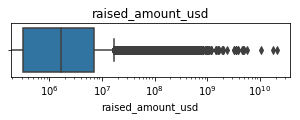

In [33]:
plt.figure(figsize=(5,1))
sns.boxplot(master_frame['raised_amount_usd'])
plt.title('raised_amount_usd')
plt.xscale('log')
plt.show()

In [34]:
master_frame.groupby('funding_round_type')['raised_amount_usd'].mean().sort_values(ascending=False)
# averages

funding_round_type
post_ipo_debt           168,704,571.82
post_ipo_equity          82,182,493.87
secondary_market         79,649,630.10
private_equity           73,308,593.03
undisclosed              19,242,370.23
debt_financing           17,043,526.02
venture                  11,748,949.13
grant                     4,300,576.34
convertible_note          1,453,438.54
product_crowdfunding      1,363,131.07
angel                       958,694.47
seed                        719,818.00
equity_crowdfunding         538,368.21
non_equity_assistance       411,203.05
Name: raised_amount_usd, dtype: float64

In [35]:
master_frame.groupby('funding_round_type')['raised_amount_usd'].median().sort_values(ascending=False)

funding_round_type
secondary_market        32,600,000.00
private_equity          20,000,000.00
post_ipo_debt           19,950,000.00
post_ipo_equity         12,262,852.50
venture                  5,000,000.00
debt_financing           1,100,000.00
undisclosed              1,018,680.00
angel                      400,000.00
seed                       275,000.00
convertible_note           272,000.00
grant                      201,684.00
product_crowdfunding       183,915.00
equity_crowdfunding        100,000.00
non_equity_assistance       60,000.00
Name: raised_amount_usd, dtype: float64

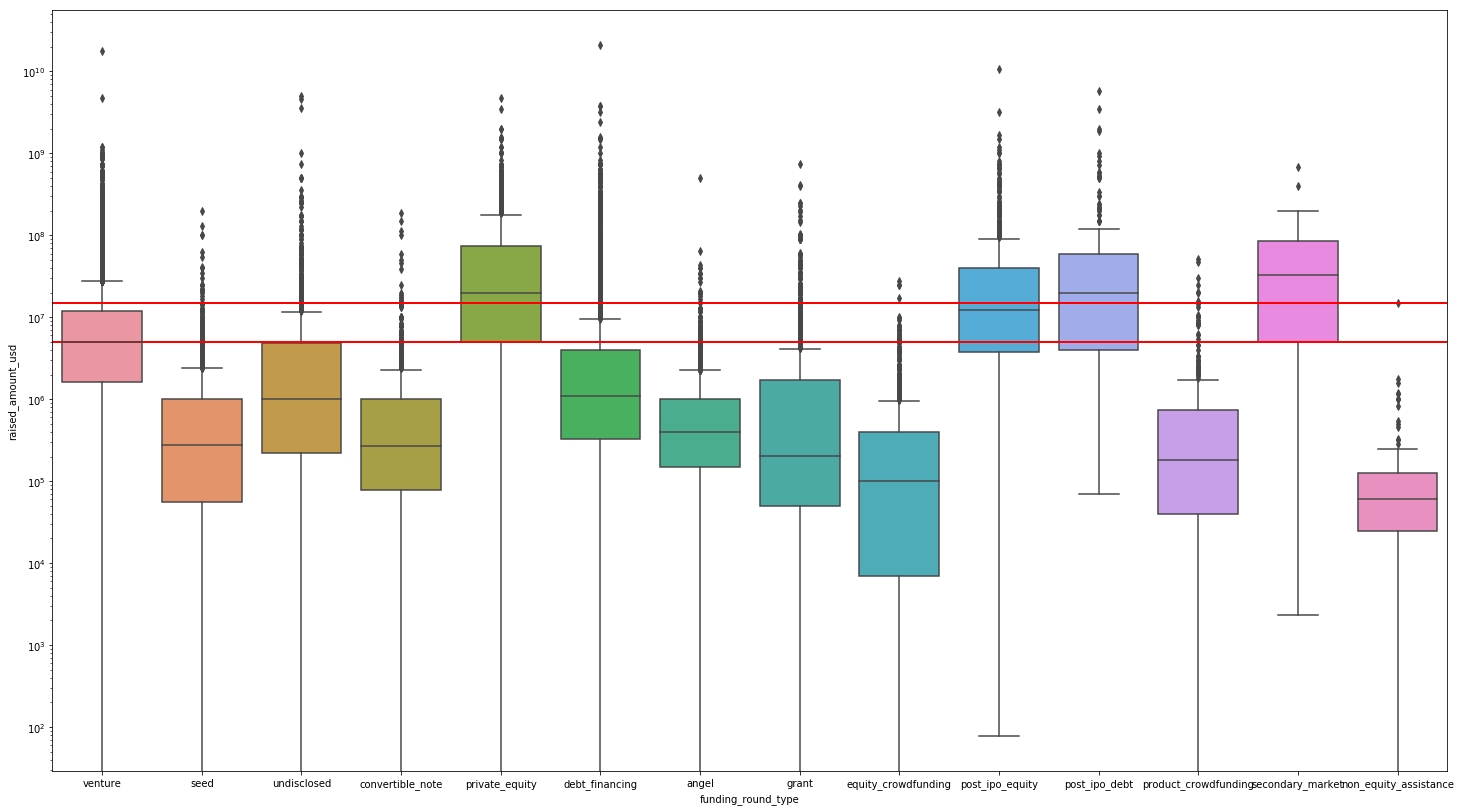

In [36]:
#boxplot to show distribution of funding_round_type
plt.figure(figsize=(25,14))
sns.boxplot(x='funding_round_type', y='raised_amount_usd', data=master_frame)
plt.yscale('log')
plt.axhline(y=5000000, linewidth=2, color='r') #these lines represent the range of investment(5-15 million)
plt.axhline(y=15000000, linewidth=2, color='r')
plt.show()

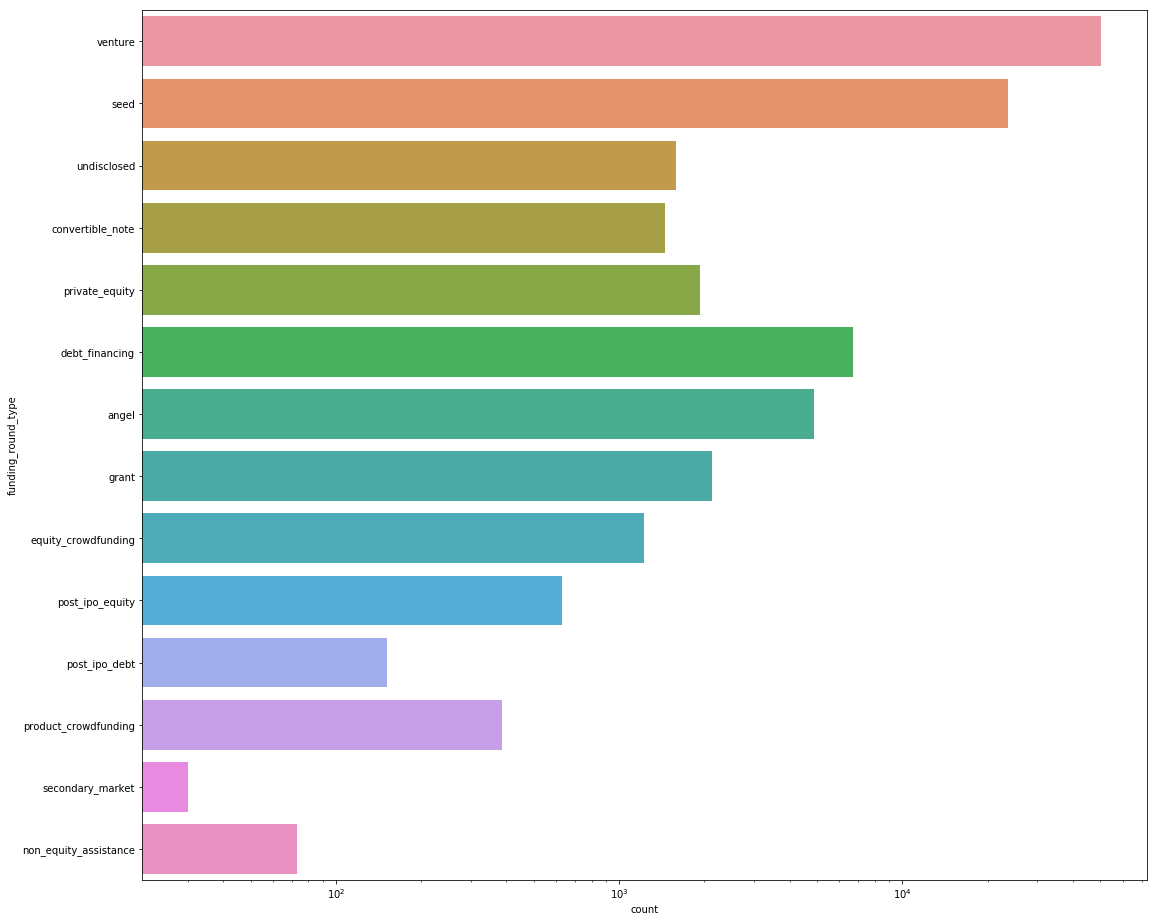

In [37]:
# Plotting count across a categorical variable
plt.figure(figsize=(18,16))
sns.countplot(y="funding_round_type", data=master_frame)
plt.xscale('log')
plt.show()

The funding types such as __*seed, venture, angel*__, etc. depend on the type of the company (startup, corporate, etc.), its stage (early stage startup, funded startup, etc.), the amount of funding (a few million USD to a billion USD), and so on. For example, seed, angel and venture are three common stages of startup funding.

__*Seed/angel*__ funding refer to early stage startups whereas venture funding occurs after seed or angel stage/s and involves a relatively higher amount of investment. Private equity type investments are associated with much larger companies and involve much higher investments than venture type. Startups which have grown in scale may also receive private equity funding. This means that if a company has reached the venture stage, it would have already passed through the angel or seed stage/s.

Spark Funds wants to choose one of these four investment types for each potential investment they will make.

In [38]:
# Lets now restrict our master frame to only contain the 4 type of funding rounds
master_frame = master_frame[master_frame['funding_round_type'].isin(
    ['venture', 'angel', 'seed', 'private_equity'])]

Calculating the most representative value of the investment amount for each of the four funding types (venture, angel, seed, and private equity) 


here we calculate mean and median.

In [39]:
master_frame.groupby(by='funding_round_type')['raised_amount_usd'].mean().sort_values(ascending = False)

funding_round_type
private_equity   73,308,593.03
venture          11,748,949.13
angel               958,694.47
seed                719,818.00
Name: raised_amount_usd, dtype: float64

C:\Users\Sheshu\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


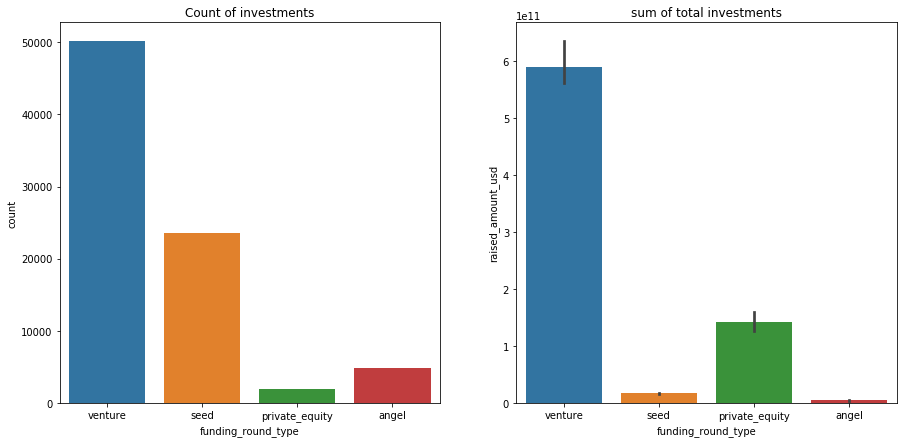

In [40]:
# boxplot of a variable across various funding categories
plt.figure(figsize=(15, 7))

plt.subplot(1,2,1)
sns.countplot(x='funding_round_type', data=master_frame)
plt.title('Count of investments')

plt.subplot(1,2,2)
sns.barplot(x='funding_round_type', y= 'raised_amount_usd', data=master_frame, estimator=np.sum)
plt.title('sum of total investments')
plt.show()

C:\Users\Sheshu\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


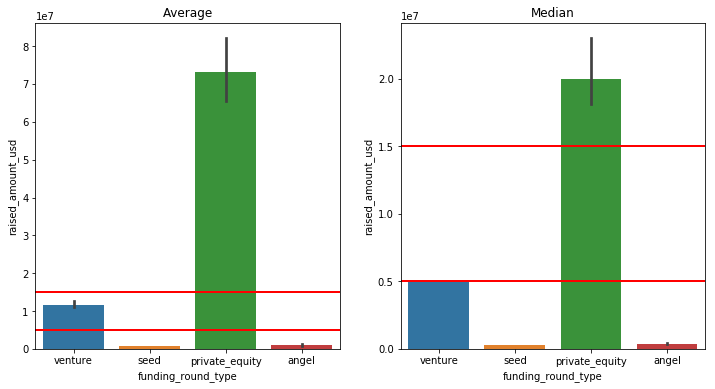

In [41]:
# Create 2 subplots for mean and median respectively

# increase figure size 
plt.figure(figsize=(12, 6))

# subplot 1: statistic=mean
plt.subplot(1, 2, 1)
sns.barplot(x='funding_round_type', y='raised_amount_usd', data=master_frame)
plt.title("Average")
plt.axhline(y=5000000, linewidth=2, color='r') #lower limit of investment - 5000000 USD
plt.axhline(y=15000000, linewidth=2, color='r') #upper limit of investment - 15000000 USD

# subplot 2: statistic=median
plt.subplot(1, 2, 2)
sns.barplot(x='funding_round_type', y='raised_amount_usd', data=master_frame, estimator=np.median)
plt.title("Median")
plt.axhline(y=5000000, linewidth=2, color='r') #lower limit of investment - 5000000 USD
plt.axhline(y=15000000, linewidth=2, color='r') #upper limit of investment - 15000000 USD

plt.show()

from the above observation we can deduce that __Venture__ type funding is best suited among others for spark funds requirements. As it falls within the investment bracket of __5 to 15 Million USD__ and also most of the investments are made in this type.

In [42]:
# Let's limit our data to only include venture type
master_frame = master_frame[master_frame['funding_round_type']=='venture']
master_frame.describe()

,raised_amount_usd
count,"50,228.00"
mean,"11,748,949.13"
std,"86,352,066.56"
min,0.00
25%,"1,600,901.75"
50%,"5,000,000.00"
75%,"12,000,000.00"
max,"17,600,000,000.00"


### Country Analysis

In [43]:
#Total investment amount raised for Venture type funding in each country
master_frame.groupby(by='country_code')['raised_amount_usd'].sum().sort_values(ascending = False)[0:10]

country_code
USA       422,510,842,796.00
CHN        39,835,418,773.00
Unknown    25,506,108,414.00
GBR        20,245,627,416.00
IND        14,391,858,718.00
CAN         9,583,332,317.00
FRA         7,259,536,732.00
ISR         6,907,514,579.00
DEU         6,346,959,822.00
JPN         3,363,676,611.00
Name: raised_amount_usd, dtype: float64

Spark funds wants to invest in countries with the highest amount of funding for the chosen investment type. 

In [44]:
#sorted list of names of countries based on highest total amount
names_of_top9 = ['USA', 'CHN', 'GBR', 'IND', 'CAN', 'FRA', 'ISR', 'DEU', 'JPN' ]

In [45]:
# Filtering top 9 countries based on the total investment amount
top9_countries = master_frame[master_frame['country_code'].isin(names_of_top9)]

#### Identify the top three English-speaking countries

C:\Users\Sheshu\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


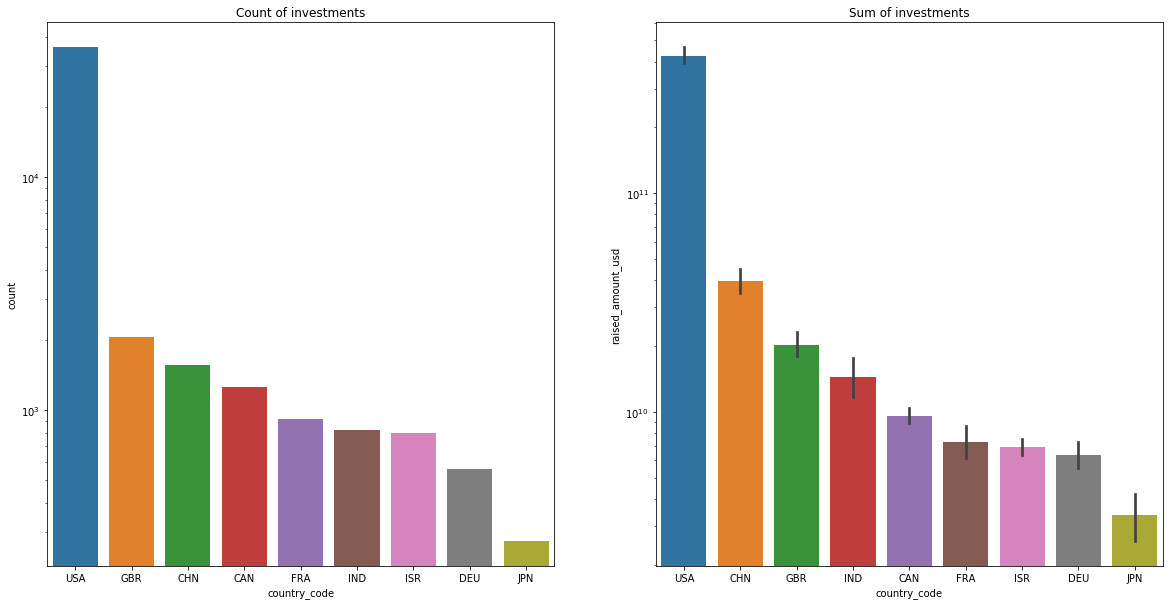

In [46]:
# Plotting sum across top 9 country_code
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.countplot(x="country_code", data=top9_countries, order=list(top9_countries.groupby(
    by='country_code').raised_amount_usd.count().sort_values(ascending=False).index))
plt.yscale('log')
plt.title("Count of investments")


plt.subplot(1, 2, 2)
sns.barplot(x="country_code", y="raised_amount_usd",
            data=top9_countries, estimator=sum, order=names_of_top9)
plt.yscale('log')
plt.title("Sum of investments")
plt.show()

list of countries where english is the official language

In [47]:
pdfFileObj = open(file4, 'rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

In [48]:
pageObj = pdfReader.getPage(0)
page1 = pageObj.extractText()
page1

'ListofcountrieswhereEnglishisanofficiallanguage\nAfricaBotswanaCameroonEthiopiaEritrea\nTheGambiaGhanaKenyaLesothoLiberiaMalawiMauritiusNamibiaNigeriaRwandaSeychellesSierraLeone\nSouthAfricaSouthSudanSudanSwazilandTanzaniaUgandaZambiaZimbabwe\nAmericasAntiguaandBarbudaTheBahamas\nBarbadosBelizeCanadaDominicaGrenadaGuyanaJamaicaSaintKittsandNevisSaintLuciaSaintVincentandtheGrenadinesTrinidadandTobago\nUnitedStates\n\nAsiaIndiaPakistanPhilippinesSingaporeAustralia/OceaniaAustraliaFijiKiribatiMarshallIslandsFederatedStates\nofMicronesiaNauruNewZealand\nPalauPapuaNewGuineaSamoaSolomonIslands\nTongaTuvaluVanuatu\nEuropeIrelandMaltaUnitedKingdom\n'

In [49]:
# strip away page header
page1 = page1[47:]

#replacing new line characters 
page1 = page1.replace('\n \n',', ').replace('\n','')

In [50]:
#getting the list of all countries from pycountries module
c = list(pycountry.countries)
cname = [c[i].name for i in range(0, len(c))]

In [51]:
#filter out countries where english is the official language
c_eng = list(filter(lambda x: x in page1, cname))

In [52]:
print(c_eng)

['Australia', 'Bahamas', 'Belize', 'Barbados', 'Botswana', 'Canada', 'Cameroon', 'Dominica', 'Eritrea', 'Ethiopia', 'Fiji', 'Ghana', 'Guinea', 'Gambia', 'Grenada', 'Guyana', 'India', 'Ireland', 'Jamaica', 'Kenya', 'Kiribati', 'Liberia', 'Lesotho', 'Malta', 'Mauritius', 'Malawi', 'Namibia', 'Niger', 'Nigeria', 'Nauru', 'Pakistan', 'Philippines', 'Palau', 'Rwanda', 'Sudan', 'Singapore', 'Swaziland', 'Seychelles', 'Tonga', 'Tuvalu', 'Uganda', 'Vanuatu', 'Samoa', 'Zambia', 'Zimbabwe']


In [53]:
#Names of top 9 countries with highest funding
list(map(lambda x : pycountry.countries.get(alpha_3 = x).name, names_of_top9))

['United States',
 'China',
 'United Kingdom',
 'India',
 'Canada',
 'France',
 'Israel',
 'Germany',
 'Japan']

After the analysis above and comparing the list with dataframe __top 9_countries__, we get the following top 3 countries with highest investments and english as official language

1. __USA__
2. __GBR__
3. __IND__


###  Sector Analysis 1

In [54]:
#create a new data frame with only these 3 countires data for furthur sector wise analysis
top3_english = top9_countries[top9_countries['country_code'].isin(['USA', 'GBR', 'IND'])]

In [55]:
df_sector_mapping.sample(5)

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
196,Digital Entertainment,0,0,0,1,0,0,0,0,0
523,Photo Sharing,0,0,0,1,0,0,0,0,0
357,Incentives,0,0,0,0,0,0,0,0,1
333,High School Students,0,0,0,0,0,0,0,1,0
414,Local Businesses,0,0,0,0,0,0,0,1,0


from visual analysis it can be seen that some values in the categories_list are not proper. the string  __'na'__ is replaced with __'0'__

In [56]:
#cleaning the names in category_list
df_sector_mapping.category_list = df_sector_mapping.category_list.apply(lambda x : str(x).strip().upper().replace('0', 'NA'))

In [57]:
df_sector_mapping.sample(10)

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
391,JOURNALISM,0,0,0,0,0,0,1,0,0
344,HOSPITALS,0,0,0,0,1,0,0,0,0
598,SKILL ASSESSMENT,0,0,0,0,0,0,0,1,0
546,PROFESSIONAL NETWORKING,0,0,0,0,0,0,1,0,0
333,HIGH SCHOOL STUDENTS,0,0,0,0,0,0,0,1,0
485,OFFICE SPACE,0,0,0,0,0,0,0,1,0
302,GAY & LESBIAN,0,0,0,0,0,0,0,1,0
219,EDA TOOLS,0,0,0,0,0,0,0,1,0
311,GOVERNMENT INNOVATION,0,0,0,0,0,0,0,1,0
518,PERSONALIZATION,0,0,0,0,0,0,0,1,0


In [58]:
df_sector_mapping.columns

Index(['category_list', 'Automotive & Sports', 'Blanks',
       'Cleantech / Semiconductors', 'Entertainment', 'Health',
       'Manufacturing', 'News, Search and Messaging', 'Others',
       'Social, Finance, Analytics, Advertising'],
      dtype='object')

In [59]:
# major sectors
sectors = ['Automotive & Sports', 'Cleantech / Semiconductors', 'Entertainment', 'Health',
           'Manufacturing', 'News, Search and Messaging', 'Others',
           'Social, Finance, Analytics, Advertising']

In [60]:
#converting the columns as row values
df_sector_mapping = df_sector_mapping.melt(id_vars=['category_list'], value_vars=sectors)

In [61]:
df_sector_mapping = df_sector_mapping[df_sector_mapping['value'] == 1]

In [62]:
df_sector_mapping.sample(5)

,category_list,variable,value
4522,KNOWLEDGE MANAGEMENT,Others,1
5183,INFORMATION TECHNOLOGY,"Social, Finance, Analytics, Advertising",1
4248,COLLEGE CAMPUSES,Others,1
5421,SOCIAL BUSINESS,"Social, Finance, Analytics, Advertising",1
4842,ANYTHING CAPITAL INTENSIVE,"Social, Finance, Analytics, Advertising",1


In [63]:
#dropping additional column
df_sector_mapping.drop('value', axis = 'columns', inplace = True)

In [64]:
#renaming columns
df_sector_mapping.rename(columns={'category_list':'primary_sector', 'variable':'main_sector'}, inplace = True)

In [65]:
df_sector_mapping.head(10)

,primary_sector,main_sector
8,ADVENTURE TRAVEL,Automotive & Sports
14,AEROSPACE,Automotive & Sports
45,AUTO,Automotive & Sports
46,AUTOMATED KIOSK,Automotive & Sports
47,AUTOMOTIVE,Automotive & Sports
57,BICYCLES,Automotive & Sports
69,BOATING INDUSTRY,Automotive & Sports
87,CAD,Automotive & Sports
93,CARS,Automotive & Sports
188,DESIGN,Automotive & Sports


In [66]:
#filtering primary sector from categories_list of top3 english countries.
top3_english['primary_sector'] = top3_english['category_list'].apply(lambda x : x.strip().upper().split('|')[0])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:2]


In [67]:
# sorting the columns in proper order
cols = ['company_permalink', 'name', 'funding_round_permalink', 'funding_round_type',
        'raised_amount_usd', 'country_code', 'category_list', 'primary_sector']

top3_english = top3_english[cols]

In [68]:
top3_english.sample(4)

,company_permalink,name,funding_round_permalink,funding_round_type,raised_amount_usd,country_code,category_list,primary_sector
90854,/ORGANIZATION/SMAATO,Smaato,/funding-round/d5124450673f359763bc7d470918a1bb,venture,"25,000,000.00",USA,Advertising,ADVERTISING
79972,/ORGANIZATION/QLIANCE,Qliance Medical Management,/funding-round/7691eef0a17b3b2fd2eea0817c5b1be9,venture,"6,000,000.00",USA,Health Care|Health Care Information Technology...,HEALTH CARE
18244,/ORGANIZATION/CELLERANT-THERAPEUTICS,Cellerant Therapeutics,/funding-round/7b27370bb4c82da467c1b3d6d745ce15,venture,"2,022,678.00",USA,Biotechnology,BIOTECHNOLOGY
69654,/ORGANIZATION/OCTAVIAN,Octavian,/funding-round/064e089d61d00aaab89e6369d78449aa,venture,"5,000,000.00",USA,Software,SOFTWARE


In [69]:
#merging mapping_sector and top3_english data frames on key column ; Primary sector
len(df_sector_mapping.primary_sector.unique())

687

In [70]:
len(top3_english.primary_sector.unique())

564

In [71]:
#main sectors
sectors

['Automotive & Sports',
 'Cleantech / Semiconductors',
 'Entertainment',
 'Health',
 'Manufacturing',
 'News, Search and Messaging',
 'Others',
 'Social, Finance, Analytics, Advertising']

In [72]:
set(top3_english.primary_sector.unique()) - set(df_sector_mapping.primary_sector.unique())

{'ADAPTIVE EQUIPMENT',
 'BIOTECHNOLOGY AND SEMICONDUCTOR',
 'ENTERPRISE 2.0',
 'GREENTECH',
 'NATURAL GAS USES',
 'NOT DEFINED',
 'PRODUCT SEARCH',
 'RACING',
 'RAPIDLY EXPANDING',
 'RETIREMENT',
 'SPECIALTY RETAIL'}

we only need the sector mappings which are present in the Top 3 english countries. Therefore we will merge on left join

In [73]:
missing_values(pd.merge(top3_english, df_sector_mapping, on='primary_sector', how='left'))

Sum of Missing values per column
company_permalink            0
name                         0
funding_round_permalink      0
funding_round_type           0
raised_amount_usd            0
country_code                 0
category_list                0
primary_sector               0
main_sector                230
dtype: int64


In [74]:
missing_values(pd.merge(top3_english, df_sector_mapping, on='primary_sector', how='left'), 'perc')

% of Missing values per column
company_permalink         0.00
name                      0.00
funding_round_permalink   0.00
funding_round_type        0.00
raised_amount_usd         0.00
country_code              0.00
category_list             0.00
primary_sector            0.00
main_sector               0.59
dtype: float64


Since the missing values are very low, we can drop the missing row values for primary sector from the merged data. Therefore now we merge them on inner join.

In [75]:
merged_top3_english = pd.merge(top3_english, df_sector_mapping, on='primary_sector', how='inner')

In [76]:
merged_top3_english.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            38778, 38779, 38780, 38781, 38782, 38783, 38784, 38785, 38786,
            38787],
           dtype='int64', length=38788)

In [77]:
merged_top3_english.reset_index(drop=True, inplace=True)

In [78]:
merged_top3_english.index

RangeIndex(start=0, stop=38788, step=1)

In [79]:
merged_top3_english.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38788 entries, 0 to 38787
Data columns (total 9 columns):
company_permalink          38788 non-null object
name                       38788 non-null object
funding_round_permalink    38788 non-null object
funding_round_type         38788 non-null object
raised_amount_usd          38788 non-null float64
country_code               38788 non-null object
category_list              38788 non-null object
primary_sector             38788 non-null object
main_sector                38788 non-null object
dtypes: float64(1), object(8)
memory usage: 2.7+ MB


### Sector Analysis 2

Now, the aim is to find out the most heavily invested main sectors in each of the three countries (for funding type 'Venture' and investments range of 5-15 M USD).


Splitting the frame into three frames based on each country and range of investment

In [80]:
df_C1 = merged_top3_english.loc[(merged_top3_english['country_code'] == 'USA') & (
    (merged_top3_english['raised_amount_usd'] >= 5000000) & (merged_top3_english['raised_amount_usd'] <= 15000000))]

In [81]:
df_C2 = merged_top3_english.loc[(merged_top3_english['country_code'] == 'GBR') & (
    (merged_top3_english['raised_amount_usd'] >= 5000000) & (merged_top3_english['raised_amount_usd'] <= 15000000))]

In [82]:
df_C3 = merged_top3_english.loc[(merged_top3_english['country_code'] == 'IND') & (
    (merged_top3_english['raised_amount_usd'] >= 5000000) & (merged_top3_english['raised_amount_usd'] <= 15000000))]

In [83]:
top_C = {'United States': df_C1,
         'United Kingdom': df_C2,
         'India': df_C3}

In [84]:
for k, v in top_C.items():
    print('\n\n Info for Country: {}\n'.format(k))
    print(v.info())



 Info for Country: United States

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12063 entries, 4 to 38781
Data columns (total 9 columns):
company_permalink          12063 non-null object
name                       12063 non-null object
funding_round_permalink    12063 non-null object
funding_round_type         12063 non-null object
raised_amount_usd          12063 non-null float64
country_code               12063 non-null object
category_list              12063 non-null object
primary_sector             12063 non-null object
main_sector                12063 non-null object
dtypes: float64(1), object(8)
memory usage: 942.4+ KB
None


 Info for Country: United Kingdom

<class 'pandas.core.frame.DataFrame'>
Int64Index: 621 entries, 1 to 38776
Data columns (total 9 columns):
company_permalink          621 non-null object
name                       621 non-null object
funding_round_permalink    621 non-null object
funding_round_type         621 non-null object
raised_amount_usd       

In [85]:
for k,v in top_C.items():
    v.reset_index(drop=True, inplace=True)

In [86]:
for k,v in top_C.items():
    print('\n\n Sum of investments in each sector for country: {}\n'.format(k))
    print(v.groupby(by='main_sector')['raised_amount_usd'].sum().sort_values(ascending = False))



 Sum of investments in each sector for country: United States

main_sector
Others                                    26,321,007,002.00
Social, Finance, Analytics, Advertising   23,807,376,964.00
Cleantech / Semiconductors                21,633,430,822.00
News, Search and Messaging                13,971,567,428.00
Health                                     8,211,859,357.00
Manufacturing                              7,258,553,378.00
Entertainment                              5,099,197,982.00
Automotive & Sports                        1,454,104,361.00
Name: raised_amount_usd, dtype: float64


 Sum of investments in each sector for country: United Kingdom

main_sector
Others                                    1,283,624,289.00
Cleantech / Semiconductors                1,163,990,056.00
Social, Finance, Analytics, Advertising   1,089,404,014.00
News, Search and Messaging                  615,746,235.00
Entertainment                               482,784,687.00
Manufacturing                 

In [87]:
for k,v in top_C.items():
    print('\n\n Number of investments in each sector for country: {}\n'.format(k))
    print(v.groupby(by='main_sector')['raised_amount_usd'].count().sort_values(ascending = False))



 Number of investments in each sector for country: United States

main_sector
Others                                     2950
Social, Finance, Analytics, Advertising    2714
Cleantech / Semiconductors                 2350
News, Search and Messaging                 1583
Health                                      909
Manufacturing                               799
Entertainment                               591
Automotive & Sports                         167
Name: raised_amount_usd, dtype: int64


 Number of investments in each sector for country: United Kingdom

main_sector
Others                                     147
Social, Finance, Analytics, Advertising    133
Cleantech / Semiconductors                 130
News, Search and Messaging                  73
Entertainment                               56
Manufacturing                               42
Health                                      24
Automotive & Sports                         16
Name: raised_amount_usd, dtype: int64


 

In [88]:
for k,v in top_C.items():
    v['number_of_investments'] = v.groupby(by='main_sector')['raised_amount_usd'].transform('count')
    v['total_sum_investments'] = v.groupby(by='main_sector')['raised_amount_usd'].transform('sum')

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:2]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:3]


In [89]:
df_C1.sample(5)

,company_permalink,name,funding_round_permalink,funding_round_type,raised_amount_usd,country_code,category_list,primary_sector,main_sector,number_of_investments,total_sum_investments
8693,/ORGANIZATION/INSITE-WIRELESS,InSite Wireless,/funding-round/9936e1b5d117f871095e480c99402b21,venture,"7,000,000.00",USA,Mobile,MOBILE,"News, Search and Messaging",1583,"13,971,567,428.00"
5300,/ORGANIZATION/SCANBUY,Scanbuy,/funding-round/62e5f73503bd2a2b9514dfd26bf5d5a5,venture,"5,262,082.00",USA,Advertising|Data Visualization|Enterprise Soft...,ADVERTISING,"Social, Finance, Analytics, Advertising",2714,"23,807,376,964.00"
11501,/ORGANIZATION/BAYNOTE,Baynote,/funding-round/ab8cd9029717774ebfd64ea000a5f04e,venture,"10,750,000.00",USA,Reviews and Recommendations|Search|Software|We...,REVIEWS AND RECOMMENDATIONS,Entertainment,591,"5,099,197,982.00"
5854,/ORGANIZATION/SOLARIA,Solaria,/funding-round/e284cf3ffae0ef665a3cdbefe16d8157,venture,"8,063,491.00",USA,Clean Technology,CLEAN TECHNOLOGY,Cleantech / Semiconductors,2350,"21,633,430,822.00"
2961,/ORGANIZATION/CBA-PHARMA,CBA PHARMA,/funding-round/31c97470b4e10d7a73ef579471b84458,venture,"5,300,486.00",USA,Biotechnology,BIOTECHNOLOGY,Cleantech / Semiconductors,2350,"21,633,430,822.00"


In [90]:
df_C2.sample(5)

,company_permalink,name,funding_round_permalink,funding_round_type,raised_amount_usd,country_code,category_list,primary_sector,main_sector,number_of_investments,total_sum_investments
537,/ORGANIZATION/ALFRESCO,Alfresco,/funding-round/31e53d286c451b905ffaade895f4a83e,venture,"8,000,000.00",GBR,Document Management|Enterprises|Enterprise Sof...,DOCUMENT MANAGEMENT,Others,147,"1,283,624,289.00"
414,/ORGANIZATION/YASA-MOTORS,YASA Motors,/funding-round/efcaffce05cb7a252310c45f25ef9382,venture,"7,576,257.00",GBR,Automotive,AUTOMOTIVE,Automotive & Sports,16,"167,051,565.00"
536,/ORGANIZATION/ALFRESCO,Alfresco,/funding-round/0db504d02c87c2b963283fd3c6d17594,venture,"13,000,000.00",GBR,Document Management|Enterprises|Enterprise Sof...,DOCUMENT MANAGEMENT,Others,147,"1,283,624,289.00"
343,/ORGANIZATION/XCONNECT,XConnect Global Networks,/funding-round/e00a5959064408fee621e126b625e137,venture,"12,000,000.00",GBR,Messaging|VoIP,MESSAGING,"News, Search and Messaging",73,"615,746,235.00"
532,/ORGANIZATION/PSYTECHNICS,Psytechnics,/funding-round/e65bc20389fa0229280f860748aeb0a2,venture,"11,600,000.00",GBR,Public Relations,PUBLIC RELATIONS,"Social, Finance, Analytics, Advertising",133,"1,089,404,014.00"


In [91]:
df_C3.sample(5)

,company_permalink,name,funding_round_permalink,funding_round_type,raised_amount_usd,country_code,category_list,primary_sector,main_sector,number_of_investments,total_sum_investments
226,/ORGANIZATION/QYUKI,Qyuki,/funding-round/94a8a24fa275da6ae289b8df26f42291,venture,"10,000,000.00",IND,Collaboration|Creative|Curated Web|Music,COLLABORATION,"Social, Finance, Analytics, Advertising",60,"550,549,550.00"
18,/ORGANIZATION/IPROF-LEARNING-SOLUTIONS,iProf Learning Solutions,/funding-round/0b08b0e63e79c8d76d2b37e8425009da,venture,"9,000,000.00",IND,Education,EDUCATION,Others,110,"1,013,409,507.00"
5,/ORGANIZATION/MANTHAN-SYSTEMS,Manthan Systems,/funding-round/384bb8d8bc2a9a1df097f6a4c60e12dc,venture,"15,000,000.00",IND,Analytics|Big Data Analytics|Business Intellig...,ANALYTICS,"Social, Finance, Analytics, Advertising",60,"550,549,550.00"
240,/ORGANIZATION/MINGLEBOX,Minglebox,/funding-round/a7a249fb0e30627e5d533584a83df749,venture,"7,000,000.00",IND,Social Media,SOCIAL MEDIA,"Social, Finance, Analytics, Advertising",60,"550,549,550.00"
49,/ORGANIZATION/CANVERA-DIGITAL-TECHNOLOGIES,Canvera Digital Technologies,/funding-round/26650720abe4be67bb6550fd4ee6d063,venture,"6,500,000.00",IND,Software,SOFTWARE,Others,110,"1,013,409,507.00"


##### As we can see, the top 3 sectors in top 3 countries based on total number of investments in each sector are
__United States__
1. Others
2. Social, Finance, Analytics, Advertising
3. Cleantech / Semiconductors 

__United Kingdom__
1. Others
2. Social, Finance, Analytics, Advertising
3. Cleantech / Semiconductors

__India__
1. Others
2. Social, Finance, Analytics, Advertising
3. News, Search and Messaging 

In [92]:
result_df = pd.concat([df_C1, df_C2, df_C3])
result_df.reset_index(drop=True, inplace=True)

In [93]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13012 entries, 0 to 13011
Data columns (total 11 columns):
company_permalink          13012 non-null object
name                       13012 non-null object
funding_round_permalink    13012 non-null object
funding_round_type         13012 non-null object
raised_amount_usd          13012 non-null float64
country_code               13012 non-null object
category_list              13012 non-null object
primary_sector             13012 non-null object
main_sector                13012 non-null object
number_of_investments      13012 non-null int64
total_sum_investments      13012 non-null float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.1+ MB


In [94]:
#total number of investments in each country
result_df.pivot_table(index=['country_code'], columns=['main_sector'])['number_of_investments'].sum(axis=1)

country_code
GBR      621
IND      328
USA    12063
dtype: int64

In [95]:
#total sum of investments in each country
result_df.pivot_table(index=['country_code'], values='total_sum_investments',columns='main_sector').sum(axis=1)

country_code
GBR     5,379,078,691.00
IND     2,949,543,602.00
USA   107,757,097,294.00
dtype: float64

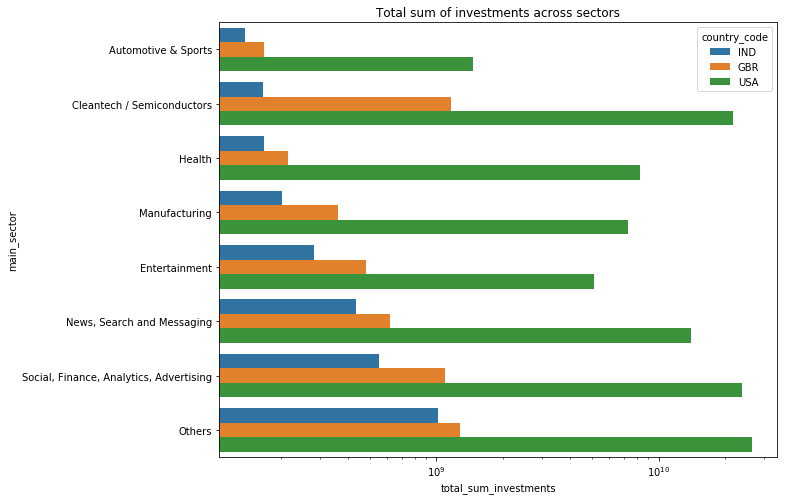

In [96]:
plt.figure(figsize=(10, 8))
sns.barplot(y="main_sector", x = 'total_sum_investments',data=result_df.sort_values(by='total_sum_investments'),  hue='country_code')
plt.xscale('log')
plt.title("Total sum of investments across sectors")
plt.show()

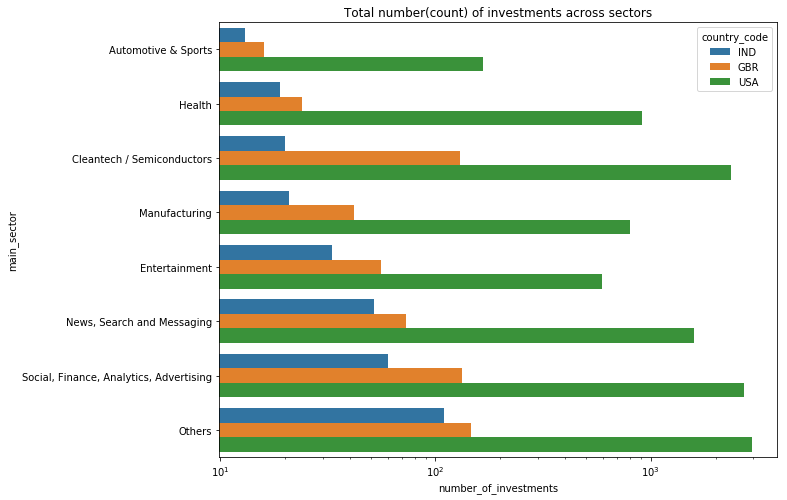

In [97]:
plt.figure(figsize=(10, 8))
sns.barplot(y='main_sector', x='number_of_investments', hue="country_code", data=result_df.sort_values(by='number_of_investments'))
plt.xscale('log')
plt.title('Total number(count) of investments across sectors')
plt.show()

### Plot

In [98]:
#top 3 sectors list for each country
su = ['Others', 'Social, Finance, Analytics, Advertising', 'Cleantech / Semiconductors']
si = ['Others', 'Social, Finance, Analytics, Advertising', 'News, Search and Messaging']

In [99]:
df_C1_3 = df_C1[df_C1['main_sector'].isin(su)]
df_C2_3 = df_C2[df_C2['main_sector'].isin(su)]
df_C3_3 = df_C3[df_C3['main_sector'].isin(si)]

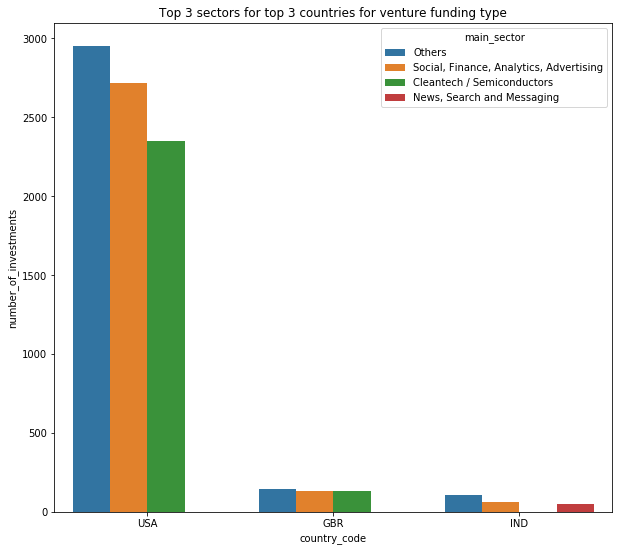

In [100]:
plt.figure(figsize=(10, 9))
results_2 = pd.concat([df_C1_3, df_C2_3, df_C3_3])
sns.barplot(x='country_code',y='number_of_investments', hue="main_sector", data=results_2.sort_values(by='number_of_investments', ascending=False))
plt.title('Top 3 sectors for top 3 countries for venture funding type')
plt.show()

In [101]:
df_C1_3[df_C1_3['main_sector']=='Others'].groupby(by=['country_code','company_permalink'])['raised_amount_usd'].sum().sort_values(ascending=False)[:2]

country_code  company_permalink        
USA           /ORGANIZATION/VIRTUSTREAM   64,300,000.00
              /ORGANIZATION/CAPELLA       54,968,051.00
Name: raised_amount_usd, dtype: float64

In [102]:
df_C2_3[df_C2_3['main_sector']=='Others'].groupby(by=['country_code','company_permalink'])['raised_amount_usd'].sum().sort_values(ascending=False)[:2]

country_code  company_permalink           
GBR           /ORGANIZATION/ELECTRIC-CLOUD   37,000,000.00
              /ORGANIZATION/SENSAGE          36,250,000.00
Name: raised_amount_usd, dtype: float64

In [103]:
df_C3_3[df_C3_3['main_sector']=='Others'].groupby(by=['country_code','company_permalink'])['raised_amount_usd'].sum().sort_values(ascending=False)[:2]

country_code  company_permalink         
IND           /ORGANIZATION/FIRSTCRY-COM   39,000,000.00
              /ORGANIZATION/MYNTRA         38,000,000.00
Name: raised_amount_usd, dtype: float64

In [104]:
df_C1_3[df_C1_3['main_sector']=='Social, Finance, Analytics, Advertising'].groupby(by=['country_code','company_permalink'])['raised_amount_usd'].sum().sort_values(ascending=False)[:2]

country_code  company_permalink        
USA           /ORGANIZATION/SHOTSPOTTER   67,933,006.00
              /ORGANIZATION/DEMANDBASE    63,000,000.00
Name: raised_amount_usd, dtype: float64

In [105]:
df_C2_3[df_C2_3['main_sector']=='Social, Finance, Analytics, Advertising'].groupby(by=['country_code','company_permalink'])['raised_amount_usd'].sum().sort_values(ascending=False)[:2]

country_code  company_permalink                  
GBR           /ORGANIZATION/CELLTICK-TECHNOLOGIES   37,500,000.00
              /ORGANIZATION/MYTHINGS                34,000,000.00
Name: raised_amount_usd, dtype: float64

In [106]:
df_C3_3[df_C3_3['main_sector']=='Social, Finance, Analytics, Advertising'].groupby(by=['country_code','company_permalink'])['raised_amount_usd'].sum().sort_values(ascending=False)[:2]

country_code  company_permalink            
IND           /ORGANIZATION/MANTHAN-SYSTEMS   50,700,000.00
              /ORGANIZATION/KOMLI-MEDIA       28,000,000.00
Name: raised_amount_usd, dtype: float64